In [1]:
import os
import sys
files = ['DateTime_lib','DataFrame_lib','FileWrite_lib','FileRead_lib','FindReplace_lib',
         'ml_utils_lib','ml_viz_lib','Utilities_lib','Stats_lib']
for file in files:
    file_dir = os.path.dirname(r"/home/myshubhlife/Desktop/FinIPScripts/myPythonLib/utils/{file}")
    sys.path.append(file_dir)

file_dir1 = os.path.dirname(r"/home/myshubhlife/Desktop/FinIPScripts/myPythonLib/MachineLearning/NonKerasClassifier_lib")
sys.path.append(file_dir1)

file_dir2 = os.path.dirname(r"/home/myshubhlife/Desktop/Aniket Code/myPythonLib/addmypaths")
sys.path.append(file_dir2)

In [2]:
import pandas as pd
import numpy as np
import ast 
import re
import joblib as joblib
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from collections import OrderedDict
import requests

import DateTime_lib as dt_lib
import NonKerasClassifier_lib as nkc_lib
import DataFrame_lib as df_lib
import DateTime_lib as dt_lib
import FileWrite_lib as fw_lib
import FileRead_lib as fr_lib
import FindReplace_lib as fire_lib
import ml_utils_lib as ml_utils
import ml_viz_lib as ml_viz
import Utilities_lib as utils_lib
import Stats_lib as stats_lib
import AccuracyMetrics_lib as am_lib

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [4]:
def feature_importance_df(mdl,mdlFeatures,deciroundoff=5):
    
    numfeatures = len(mdlFeatures)
    
    # Feature Importance
    featureImportance_GINI = mdl.feature_importances_
    
    # Feature importance df
    f=[]
    for i in range(numfeatures):
        f_i  = mdlFeatures[i]
        fi_i = np.round(featureImportance_GINI[i],deciroundoff)        
        f.append([f_i,fi_i])
        
    df_fi = pd.DataFrame(np.array(f),columns=['feature', 'importance'])
    df_fi.sort_values(by=['importance'],ascending=False,inplace=True)
    df_fi.set_index(['feature'],inplace=True)
    return df_fi

#%%
def func_GetDFRows(df,colhdr,elemType1,relType1='eq',elemType2=np.float('Inf'),relType2=''):
   
    if relType1 == 'eq' and relType2=='':
        df1  = df.loc[(df[colhdr] == elemType1)]
    elif relType1 == 'neq' and relType2=='':
        df1  = df.loc[(df[colhdr] != elemType1)]
    elif relType1 == 'gt' and relType2=='':
        df1  = df.loc[(df[colhdr] > elemType1)]
    elif relType1 == 'lt' and relType2=='':
        df1  = df.loc[(df[colhdr] < elemType1)]
    elif relType1 == 'geq' and relType2=='':
        df1  = df.loc[(df[colhdr] >= elemType1)]
    elif relType1 == 'leq' and relType2=='':
        df1  = df.loc[(df[colhdr] <= elemType1)]
    elif relType1 == 'gt' and relType2=='lt':
        df1 = df[(df[colhdr] > elemType1) & (df[colhdr] < elemType2)]
    elif relType1 == 'geq' and relType2=='lt':
        df1 = df[(df[colhdr] >= elemType1) & (df[colhdr] < elemType2)]
    elif relType1 == 'gt' and relType2=='leq':
        df1 = df[(df[colhdr] > elemType1) & (df[colhdr] <= elemType2)]
    elif relType1 == 'geq' and relType2=='leq':
        df1 = df[(df[colhdr] >= elemType1) & (df[colhdr] <= elemType2)]
        
    return (df1)

#%%

def func_makeDataFramefromDict(dict_in,fldnamesindex=False,dtype=None):
    fld_names = list(dict_in)
    dict_pd = {}
    for i in range(len(fld_names)):
        if dtype is None:
            dict_pd[i] = [fld_names[i],dict_in[fld_names[i]]]
        elif dtype is str:
            dict_pd[i] = [fld_names[i],str(dict_in[fld_names[i]])]
        elif dtype is int:
            dict_pd[i] = [fld_names[i],int(dict_in[fld_names[i]])]
        elif dtype is float:
            dict_pd[i] = [fld_names[i],float(dict_in[fld_names[i]])]
        else:
            dict_pd[i] = [fld_names[i],dict_in[fld_names[i]]]
    df_dict = pd.DataFrame(dict_pd).T
    if fldnamesindex==True:
        df_dict.set_index(0,inplace=True)
    return df_dict

#%%
def all_attribute_permutations(control_var_levels):
    df_start = control_var_levels[0]
    for i in range(1,len(control_var_levels)):
        df_next = control_var_levels[i]
        df_super_combo_list = []
        for j in range(len(df_start)):
            df_start_j = df_start.iloc[[j]]
            df_combo_list=[]
            for k in range(len(df_next)):
                df_next_k = df_next.iloc[[k]]
                df_next_k.index=df_start_j.index
                df_combo_list.append(pd.concat([df_start_j,df_next_k],axis=1))
            df_super_combo_list.append(pd.concat(df_combo_list))
        df_start = pd.concat(df_super_combo_list)
    return df_start

#%%
def map_deciles(df_prob_test,df_bins,sort_band='descending'):
    
    df_prob_test_dec = df_prob_test.copy()
    nsmpls = len(df_prob_test)
    dec_array=[]
    for i in range(len(df_prob_test_dec)):
        df_prob_i = df_prob_test_dec.iloc[[i]]
        pp_i      = df_prob_i.pos_prob.values.tolist()[0]
        found_flag=False
        row_i=0
        while found_flag==False:
            bins_row = df_bins.iloc[[row_i]]
            left_i   = bins_row.left.values.tolist()[0]
            right_i  = bins_row.right.values.tolist()[0]
            if pp_i>left_i and pp_i<=right_i:
                dec_i = bins_row.index.tolist()[0]
                dec_array.append(dec_i)
                found_flag=True
            else:
                row_i+=1
                
    df_prob_test_dec['band'] = dec_array
    
    if sort_band=='descending':
        df_prob_test_dec1 = df_prob_test_dec.sort_values(by=['band'],ascending=False,inplace=False)
    elif sort_band=='ascending':
        df_prob_test_dec1 = df_prob_test_dec.sort_values(by=['band'],ascending=True,inplace=False)
    
    bands_unq = np.flipud(np.unique(df_prob_test_dec1['band'].values))
    df_list = []
    for bnd_i in bands_unq:
        df_q  = df_lib.func_GetDFRows(df_prob_test_dec1,'band',bnd_i,'eq')
        df_q1 = df_q.sort_values(by=['pos_prob'],ascending=False,inplace=False)
        df_list.append(df_q1)
        
    df_prob_test_dec_sort = pd.concat(df_list)
    return df_prob_test_dec_sort

#%%
def deciles_split_old(df_in,hdr,bins_split=None,min_pt=None):
    
    inp = df_in[hdr].values
    
    if bins_split is None:
        bins_split=np.arange(10,110,10)
    
    if min_pt is None:
        min_pt = np.min(inp)
    
    left = min_pt
    uids_bins=OrderedDict()
    cnt=1
    left_array=[]
    right_array=[]
    for bin_i in bins_split:
        right = np.percentile(inp, bin_i, interpolation = 'midpoint')
        
        df_q  = df_lib.func_GetDFRows(df_in,hdr,left,'gt',right,'leq')
        
        left_array.append(left)
        right_array.append(right)
        
        left=right
        uids_bins[cnt]=df_q.index.tolist()
        cnt+=1
        
    df_bins = pd.DataFrame({'band':np.arange(1,len(bins_split)+1),'decile':bins_split,'left':left_array,'right':right_array})
    df_bins.set_index('band',inplace=True)
    return (uids_bins,df_bins)

#%%
def deciles_split(df_in,hdr,bins_split=None,min_pt=None,split_type='deciles'):
    
    inp = df_in[hdr].values
    
    if bins_split is None:
        if split_type=='deciles':
            bins_split=np.arange(10,110,10)
        else:
            bins_split=np.arange(0,1.1,.1)
    
    if min_pt is None:
        min_pt = np.min(inp)
    
    N = len(df_in)
    N_def = df_in['class_true'].sum()
    
    left = min_pt
    uids_bins=OrderedDict()
    cnt=1
    band_array=[]
    dec_array=[]
    left_array=[]
    right_array=[]
    num_cust_array=[]
    pcnt_cust_array=[]
    num_def_array=[]
    def_rate_array=[]
    pcnt_def_array = []
    for bin_i in bins_split:
        
        try:
            if split_type=='deciles':
                right = np.percentile(inp, bin_i, interpolation = 'midpoint')
            else:
                right = bins_split[cnt]
            
            df_q  = func_GetDFRows(df_in,hdr,left,'gt',right,'leq')
            
            # num customers and percentage
            num_cust = len(df_q)
            pcnt_cust = np.round(100*num_cust/N,2)
            # num defaulters and percentage
            num_def  = df_q['class_true'].sum()
            pcnt_def = np.round(100*num_def/N_def,2)
            # default rate
            def_rate = np.round(100*num_def/num_cust,2)
            
            band_array.append(cnt)
            dec_array.append(bin_i)
            
            left_array.append(left)
            right_array.append(right)
            
            num_cust_array.append(num_cust)
            pcnt_cust_array.append(pcnt_cust)
            num_def_array.append(num_def)
            def_rate_array.append(def_rate)
            pcnt_def_array.append(pcnt_def)
            
            left=right
            uids_bins[cnt]=df_q.index.tolist()
            cnt+=1
        except:
            pass
        
    band_array  = np.flipud(band_array)
    right_array = np.flipud(right_array)
    left_array  = np.flipud(left_array)
    pcnt_cust_array = np.flipud(pcnt_cust_array)
    
    df_bins = pd.DataFrame({'band':band_array,'decile':np.flipud(dec_array),\
                            'left':left_array,'right':right_array,\
                            'Num Cust':np.flipud(num_cust_array),'% Cust':pcnt_cust_array,\
                            'Num Def':np.flipud(num_def_array),'% Def':np.flipud(pcnt_def_array),\
                            'Def Rate':np.flipud(def_rate_array)})
    df_bins.set_index('band',inplace=True)
    df_bins.at[band_array[-1], '% Cust'] = 100-np.sum(pcnt_cust_array[0:-1])
    
    if split_type!='deciles':
        df_bins = df_bins.drop(['decile'],axis=1,inplace=False)
    
    df_bins['Cum Num Cust'] = df_bins['Num Cust'].values.cumsum()
    df_bins['Cum % Cust'] = df_bins['% Cust'].values.cumsum()
    df_bins['Cum Num Def'] = df_bins['Num Def'].values.cumsum()
    df_bins['Cum % Def'] = df_bins['% Def'].values.cumsum()
    
    #adjusting the probabilities
    df_bins.at[band_array[0], 'right'] = 1
    return (uids_bins,df_bins)




#%%
def feature_decoding(df_in,hdr,enc_key,fea_num):
    
    for key, value in enc_key.items():
        
        if fea_num is not None:
            df_in.loc[(df_in[hdr]==key),hdr+'_enc_'+str(fea_num)]=value
        else:
            df_in.loc[(df_in[hdr]==key),hdr]=value
        
    return df_in

#%%
def feature_encoding(df,cat_hdr,label_hdr,fea_num):
    
    attr_count = Counter(df[cat_hdr].values)
    enc_key = OrderedDict()
    for key, _ in attr_count.items():
        
        df_i   = df_lib.func_GetDFRows(df,cat_hdr,key,'eq')
        label_count = Counter(df_i[label_hdr].values)
        one_by_total = label_count[1]/(label_count[0]+label_count[1]) # IMPORTANT
        
        enc_key[key]=one_by_total
        
        if fea_num is not None:
            df.loc[(df[cat_hdr]==key),cat_hdr+'_enc_'+str(fea_num)]=one_by_total
        else:
            df.loc[(df[cat_hdr]==key),cat_hdr]=one_by_total
        
    return (df,enc_key)


def conf_mat_roc(y,ypred,pos_proba):
    
    # conf mat
    tn, fp, fn, tp = confusion_matrix(y, ypred).ravel()
    # ROC curve
    fpr_roc, tpr_roc, thresholds_roc = roc_curve(y, pos_proba, pos_label=1)
    # AUC
    auc = roc_auc_score(y, pos_proba)
    # accuracy metrics
    acc = am_lib.func_AccuracyMetrics(tp,tn,fp,fn)
    
    conf1=[]
    for i1 in range(len(y)):
        y_i1 = y[i1]
        yp_i1 = ypred[i1]
        if y_i1==1 and yp_i1==1:
            conf1.append('tp')
        elif y_i1==0 and yp_i1==0:
            conf1.append('tn')
        elif y_i1==1 and yp_i1==0:
            conf1.append('fn')
        elif y_i1==0 and yp_i1==1:
            conf1.append('fp')
    return (tn, fp, fn, tp,conf1,fpr_roc, tpr_roc, thresholds_roc,auc,acc)

#%%
def prediction(clf,X,y,INDEX_NAME,INDEX_IDS,Xcols,prob_threshold=0.5):
    
    # get the model parameters
    clf_params = clf.get_params()
    
    try:
        # get parameter feature importances
        featureImportance = clf.feature_importances_
        df_fi = pd.DataFrame({'features':Xcols,'importance':featureImportance})
        df_fi.sort_values(by=['importance'],ascending=False,inplace=True)
        df_fi.set_index('features',inplace=True)
    except:
        df_fi=None
        pass
    
    # probability predictions: format: [False, True]
    pred_prob = clf.predict_proba(X)
    # probability for negative label
    neg_proba = pred_prob[:,0]
    # probability for positive label
    pos_proba = pred_prob[:,1]
    
    df_prob = pd.DataFrame(data={INDEX_NAME:INDEX_IDS, 'neg_prob':neg_proba, 'pos_prob':pos_proba})
    df_prob.set_index(INDEX_NAME,inplace=True)
    df_prob.loc[(df_prob.pos_prob>=prob_threshold), 'class_pred'] = 1
    df_prob.loc[(df_prob.pos_prob<prob_threshold),  'class_pred'] = 0
    
    out = {}
    out['fi'] = df_fi
    out['pod'] = {}
    out['pod']['pos'] = pos_proba
    out['pod']['neg'] = neg_proba
    
    if y is not None:
        df_prob['class_true']=y
        ypred=df_prob['class_pred'].values
        
        tn, fp, fn, tp,conf1,fpr_roc, tpr_roc, thresholds_roc,auc,acc = conf_mat_roc(y,ypred,pos_proba)
                
        df_prob['conf'] = conf1
        
        out['conf_mat'] = {}
        out['conf_mat']['tp'] = tp
        out['conf_mat']['tn'] = tn
        out['conf_mat']['fp'] = fp
        out['conf_mat']['fn'] = fn
        out['auc'] = auc
        out['acc'] = acc
        out['roc'] = {}
        out['roc']['fpr_roc'] = fpr_roc
        out['roc']['tpr_roc'] = tpr_roc
        out['roc']['thresh_roc'] = thresholds_roc
        
    out['df_prob'] = df_prob

    return out

#%%
def plot_roc(pred_1,pred_2,leg_1,leg_2,c1='b',c2='g',lt1=':',lt2='-',w1=1,w2=1,title='ROC CURVE',fignum=1):
    plt.figure(num=fignum,figsize=(12,10))
    leg_list = []
    
    if pred_1 is not None:
        # sns.lineplot(x = pred_1['roc']['fpr_roc'], y = pred_1['roc']['tpr_roc'],linewidth=1,color='b',linestyle='--')
        plt.plot(pred_1['roc']['fpr_roc'], pred_1['roc']['tpr_roc'],color=c1,linestyle=lt1,linewidth=w1)
        leg_list.append(leg_1)
    if pred_2 is not None:
        # sns.lineplot(x = pred_2['roc']['fpr_roc'], y = pred_2['roc']['tpr_roc'],linewidth=1,color='g',linestyle='-')
        plt.plot(pred_2['roc']['fpr_roc'], pred_2['roc']['tpr_roc'],color=c2,linestyle=lt2,linewidth=w2)
        leg_list.append(leg_2)
    # plt.plot(fpr_roc_test, p0z,'g')
    # sns.lineplot(x = [0, 1], y = [0, 1], color = 'orange', linestyle='--')
    plt.plot([0,1],[0,1],color='orange',linestyle='--',linewidth=1)
    leg_list.append('Random')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid(True)
    plt.xlabel('FALSE POSITIVE RATE',fontname='Calibri',fontsize=18)
    plt.ylabel('TRUE POSITIVE RATE',fontname='Calibri',fontsize=18)
    plt.title(title,fontname='Calibri',fontsize=18)
    plt.legend(leg_list,fontsize=14)
    return

#%%
def plot_POD(pred_train,pred_test,str1,str2,bins1,bins2,fignum,figsize,stat='count',\
             hdr='pos_prob',shrink=1):
    
    df_prob_train = pred_train['df_prob']
    df_prob_test  = pred_test['df_prob']
    
    POD_train0=df_lib.func_GetDFRows(df_prob_train,'class_true',0,'eq')
    POD_train0_fp=df_lib.func_GetDFRows(POD_train0,'class_pred',1,'eq')
    POD_train0_tn=df_lib.func_GetDFRows(POD_train0,'class_pred',0,'eq')
    
    POD_train1=df_lib.func_GetDFRows(df_prob_train,'class_true',1,'eq')
    POD_train1_tp=df_lib.func_GetDFRows(POD_train1,'class_pred',1,'eq')
    POD_train1_fn=df_lib.func_GetDFRows(POD_train1,'class_pred',0,'eq')
    
    POD_test0=df_lib.func_GetDFRows(df_prob_test,'class_true',0,'eq')
    POD_test0_fp=df_lib.func_GetDFRows(POD_test0,'class_pred',1,'eq')
    POD_test0_tn=df_lib.func_GetDFRows(POD_test0,'class_pred',0,'eq')
    
    POD_test1=df_lib.func_GetDFRows(df_prob_test,'class_true',1,'eq')
    POD_test1_tp=df_lib.func_GetDFRows(POD_test1,'class_pred',1,'eq')
    POD_test1_fn=df_lib.func_GetDFRows(POD_test1,'class_pred',0,'eq')
    
    plt.figure(num=fignum,figsize=figsize)
    plt.subplot(2,2,1)
    sns_histplot(POD_train1_tp,hdr,bins1,stat,'b','--',shrink)
    sns_histplot(POD_train0_fp,hdr,bins1,stat,'r',':',shrink)
    plt.legend([str1+' TP',str1+' FP'])
    
    plt.subplot(2,2,2)
    sns_histplot(POD_train0_tn,hdr,bins1,stat,'b','--',shrink)
    sns_histplot(POD_train1_fn,hdr,bins1,stat,'r',':',shrink)
    plt.legend([str1+' TN',str1+' FN'])
    
    plt.subplot(2,2,3)
    sns_histplot(POD_test1_tp,hdr,bins2,stat,'b','--',shrink)
    sns_histplot(POD_test0_fp,hdr,bins2,stat,'r',':',shrink)
    plt.legend([str2+' TP',str2+' FP'])
    
    plt.subplot(2,2,4)
    sns_histplot(POD_test0_tn,hdr,bins2,stat,'b','--',shrink)
    sns_histplot(POD_test1_fn,hdr,bins2,stat,'r',':',shrink)
    plt.legend([str2+' TN',str2+' FN'])
    return

def sns_histplot(POD_test0_tn,hdr,bins,stat,color,linestyle,shrink):
    sns.histplot(data=POD_test0_tn, x=hdr, y=None, hue=None,\
                 weights=None, stat=stat, bins=bins, binwidth=None, binrange=None,\
                 discrete=None, cumulative=False, common_bins=True, common_norm=True,\
                 multiple='layer', element='bars', fill=False, shrink=shrink, kde=True, kde_kws=None,\
                 line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None,\
                 cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=color, log_scale=None,\
                 legend=True, linestyle=linestyle)
    return

<ipython-input-4-4169a6f3f618>:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def func_GetDFRows(df,colhdr,elemType1,relType1='eq',elemType2=np.float('Inf'),relType2=''):


In [5]:
print('')
print('====================')
print(' MARKETING DATA ')
print('====================')

pname=r'/home/myshubhlife/Projects/Marketing SMS Campaign Optimization/My Work'
fname = 'mkting_cmpgn_data_wo_existing_users'

print('\n\nDATA LOAD:')
print('   Path Name: %s'%pname)
print('   File Name: %s'%fname)

df = fr_lib.func_ReadCSVFile(pathName=pname, fileName=fname)[0]
df.set_index('SN',inplace=True)


 MARKETING DATA 


DATA LOAD:
   Path Name: /home/myshubhlife/Projects/Marketing SMS Campaign Optimization/My Work
   File Name: mkting_cmpgn_data_wo_existing_users


In [6]:
df['Median Day of Month ceil'] = df['Median Day of Month'].apply(lambda x: np.ceil(x))
df['Avg SMS Length ceil'] = df['Avg SMS Length'].apply(lambda x: np.ceil(x))

In [7]:
stratify=True

#map avg sms length
df.loc[((df['Avg SMS Length']>0) & (df['Avg SMS Length']<=180)),'Avg SMS Length_cat']='1-180'
df.loc[((df['Avg SMS Length']>180) & (df['Avg SMS Length']<=200)),'Avg SMS Length_cat']='181-200'
df.loc[((df['Avg SMS Length']>200) & (df['Avg SMS Length']<=300)),'Avg SMS Length_cat']='201-300'
df.loc[((df['Avg SMS Length']>300)),'Avg SMS Length_cat']='300+'

#map avg day of month

df.loc[((df['Avg Day of Month']>0) & (df['Avg Day of Month']<=7)),'Avg Day of Month_cat']='week_1'
df.loc[((df['Avg Day of Month']>7) & (df['Avg Day of Month']<=14)),'Avg Day of Month_cat']='week_2'
df.loc[((df['Avg Day of Month']>14) & (df['Avg Day of Month']<=21)),'Avg Day of Month_cat']='week_3'
df.loc[((df['Avg Day of Month']>21)),'Avg Day of Month_cat']='week_4'

In [8]:
df['Avg SMS Length_cat'].value_counts()

201-300    884
181-200    452
1-180      350
300+        82
Name: Avg SMS Length_cat, dtype: int64

In [9]:
df[['Delivery_Click_Rate']] = df['delivery_rate'].values*df['clicked_rate'].values/100

#%% design label
click_rate = 10
label_name = 'clicked_rate'

In [10]:
df.loc[(df[label_name]>=click_rate),'label_drate']=1
df.loc[(df[label_name]<click_rate),'label_drate']=0
df[['label_drate']] = df[['label_drate']].astype(np.int64)

In [11]:
df

,Circle,SMS Language,Day of Week,Hour of Day,sms_sent,sms_delivered,delivery_rate,sms_clicked,clicked_rate,Avg Num SMS Sent,...,Avg Num Words,Median Num Words,Avg Num Words wo 0,Median Num Words wo 0,Median Day of Month ceil,Avg SMS Length ceil,Avg SMS Length_cat,Avg Day of Month_cat,Delivery_Click_Rate,label_drate
SN,,,,,,,,,,,,,,,,,,,,,
0,Andhra Pradesh,English,Friday,9,461,438.0,95.010846,77.0,17.579909,2.0,...,29.000000,29.0,29.000000,29.0,24.0,197.0,181-200,week_4,16.702820,1
1,Andhra Pradesh,English,Friday,10,13919,7784.0,55.923558,780.0,10.020555,2.0,...,33.996767,34.0,33.996767,34.0,2.0,240.0,201-300,week_1,5.603851,1
2,Andhra Pradesh,English,Friday,11,2238,366.0,16.353887,34.0,9.289617,2.0,...,33.995532,34.0,33.995532,34.0,2.0,240.0,201-300,week_2,1.519214,0
3,Andhra Pradesh,English,Friday,12,832,633.0,76.081731,106.0,16.745656,2.0,...,36.617788,37.0,36.617788,37.0,12.0,265.0,201-300,week_2,12.740385,1
4,Andhra Pradesh,English,Friday,13,12,10.0,83.333333,0.0,0.000000,2.0,...,36.000000,37.0,36.000000,37.0,12.0,259.0,201-300,week_2,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,West Bengal-Andaman Nicobar,English,Wednesday,15,9,0.0,0.000000,0.0,0.000000,2.0,...,22.000000,22.0,22.000000,22.0,8.0,163.0,1-180,week_2,0.000000,0
1764,West Bengal-Andaman Nicobar,English,Wednesday,16,7,5.0,71.428571,0.0,0.000000,2.0,...,32.000000,32.0,32.000000,32.0,11.0,231.0,201-300,week_2,0.000000,0
1765,West Bengal-Andaman Nicobar,English,Wednesday,19,70,64.0,91.428571,10.0,15.625000,2.0,...,30.185714,29.0,30.185714,29.0,22.0,203.0,201-300,week_4,14.285714,1


In [12]:
features = ['Circle',
             'Day of Week',
             'Median Day of Month ceil',
             'Avg SMS Length_cat',
             'Hour of Day',
             'Median Num SMS Sent'
           ]

dfX = df[features]
dfy = df[['label_drate']]

print(Counter(dfy.label_drate))

Counter({0: 1019, 1: 749})


In [13]:
if stratify==True:
            dfX_train, dfX_test, dfy_train, dfy_test = \
                train_test_split(dfX.loc[dfy.index], dfy,\
                                 test_size=0.3, random_state=21, stratify=dfy)
else:
    dfX_train, dfX_test, dfy_train, dfy_test = \
        train_test_split(dfX.loc[dfy.index], dfy,\
                         test_size=0.3, random_state=21)

In [14]:
dfXy_train = pd.concat([dfX_train,dfy_train],axis=1)

In [15]:
dfXy_train,circle_enc_key   = feature_encoding(dfXy_train,'Circle','label_drate',None)
dfXy_train,weekday_enc_key  = feature_encoding(dfXy_train,'Day of Week','label_drate',None)
dfXy_train,avg_sms_len_enc_key   = feature_encoding(dfXy_train,'Avg SMS Length_cat','label_drate',None)

dfX_test = feature_decoding(dfX_test,'Circle',circle_enc_key,None)
dfX_test = feature_decoding(dfX_test,'Day of Week',weekday_enc_key,None)
dfX_test = feature_decoding(dfX_test,'Avg SMS Length_cat',avg_sms_len_enc_key,None)

dfX_train = dfXy_train[dfX_train.columns]
dfy_train = dfXy_train[dfy_train.columns]

In [16]:
X_train = dfX_train.values
X_test  = dfX_test.values
y_train = dfy_train.values.flatten()
y_test  = dfy_test.values.flatten()

In [17]:
def rf_model_build(X_train,y_train,alg='RF'):
    
    print('\n')
    if alg=='RF':
        # model - RF
        print('=====')
        print('RANDOM FOREST CLASSIFIER')
        print('=====')
        clf = RandomForestClassifier(n_estimators=200,criterion='gini',max_depth=12,min_samples_split=40,\
                                     min_samples_leaf=10,min_weight_fraction_leaf=0.0,max_features=None,\
                                     max_leaf_nodes=None,min_impurity_decrease=0.0,bootstrap=True,\
                                     oob_score=True,n_jobs=None,random_state=42,verbose=0,\
                                     warm_start=False,class_weight='balanced',\
                                     ccp_alpha=0.005*0,max_samples=None)
            
    print('\n')
    # parameters
    print(clf.get_params())
    # fit the data
    clf.fit(X_train,y_train)
    
    return clf

In [18]:
uid_train = dfX_train.index
uid_test  = dfX_test.index
Xcols     = dfX_train.columns.tolist()
INDEX_NAME = dfX_train.index.name

algtype = 'RF'
clf = rf_model_build(X_train,y_train,alg=algtype)



=====
RANDOM FOREST CLASSIFIER
=====


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 12, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 40, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [19]:
import joblib
import pathlib
import os

def func_CreateFile(pathName, fileName=None, fileExtn=None):
    
    if fileName==None:
        fileName='TEMP'
    if fileExtn==None:
        fileExtn='.xlsx'
    fileNamewithExtn = fileName+fileExtn
    fullfile = os.path.join(pathName,fileNamewithExtn)
    if os.path.exists(pathName)==False:
        pathlib.Path(pathName).mkdir(parents=True,exist_ok=True)
        
    return (fullfile)

def func_save_joblib(data,pathName,fileName)->None:
    
    fileExtn = '.sav'
    path  = func_CreateFile(pathName,fileName,fileExtn)
    joblib.dump(data, path)
    
    return

def pre_load(path_to_saved_data=None,fname_of_saved_data=None):
    
    ind1 = fname_of_saved_data.find('.')
    if ind1==-1:
        fname_of_saved_data=fname_of_saved_data+'.sav'
    fullfilesaveddata = os.path.join(path_to_saved_data,fname_of_saved_data)
    loaded_data       = joblib.load(fullfilesaveddata)
    
    return (loaded_data)

In [20]:
n_round_off = 2
print('Train Data Prediction')
pred_train = prediction(clf,X_train,y_train,INDEX_NAME,uid_train,Xcols,prob_threshold=0.45)
df_prob_train=pred_train['df_prob']
print('TPR    = %.2f%%'%np.round(100*pred_train['acc']['truepositiverate[sensitivity or recall]'],n_round_off))
print('TNR    = %.2f%%'%np.round(100*pred_train['acc']['truenegativerate[specificity]'],n_round_off))
print('FPR    = %.2f%%'%np.round(100*pred_train['acc']['falsepositiverate[fallout]'],n_round_off))
print('FNR    = %.2f%%'%np.round(100*pred_train['acc']['falsenegativerate[missrate]'],n_round_off))
print('ACC    = %.2f%%'%np.round(100*pred_train['acc']['accuracy'],n_round_off))
print('BalAcc = %.2f%%'%np.round(100*pred_train['acc']['balancedaccuracy'],n_round_off))
print('F1     = %.2f%%'%np.round(100*pred_train['acc']['f1score'],n_round_off))
print('AUC    = %.2f%%'%np.round(100*pred_train['auc'],n_round_off))

Train Data Prediction
TPR    = 86.45%
TNR    = 73.35%
FPR    = 26.65%
FNR    = 13.55%
ACC    = 78.90%
BalAcc = 79.90%
F1     = 77.63%
AUC    = 89.39%


In [21]:
print('Test Data Prediction')
pred_test  = prediction(clf,X_test,y_test,INDEX_NAME,uid_test,Xcols,prob_threshold=0.45)
df_prob_test=pred_test['df_prob']
df_prob_test=pd.concat([df_prob_test,df.loc[df_prob_test.index]],axis=1)

print('TPR    = %.2f%%'%np.round(100*pred_test['acc']['truepositiverate[sensitivity or recall]'],n_round_off))
print('TNR    = %.2f%%'%np.round(100*pred_test['acc']['truenegativerate[specificity]'],n_round_off))
print('FPR    = %.2f%%'%np.round(100*pred_test['acc']['falsepositiverate[fallout]'],n_round_off))
print('FNR    = %.2f%%'%np.round(100*pred_test['acc']['falsenegativerate[missrate]'],n_round_off))
print('ACC    = %.2f%%'%np.round(100*pred_test['acc']['accuracy'],n_round_off))
print('BalAcc = %.2f%%'%np.round(100*pred_test['acc']['balancedaccuracy'],n_round_off))
print('F1     = %.2f%%'%np.round(100*pred_test['acc']['f1score'],n_round_off))
print('AUC    = %.2f%%'%np.round(100*pred_test['auc'],n_round_off))

Test Data Prediction
TPR    = 79.11%
TNR    = 77.45%
FPR    = 22.55%
FNR    = 20.89%
ACC    = 78.15%
BalAcc = 78.28%
F1     = 75.42%
AUC    = 85.95%


In [22]:
feature_importance_df(clf,Xcols)

,importance
feature,
Hour of Day,0.41663
Median Day of Month ceil,0.2449
Day of Week,0.18202
Circle,0.11156
Avg SMS Length_cat,0.03207
Median Num SMS Sent,0.01283


findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


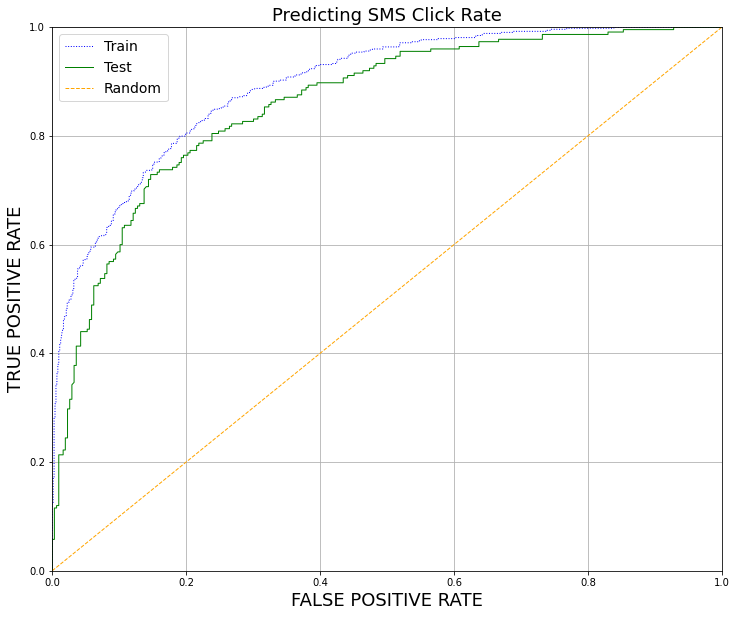

In [23]:
plot_roc(pred_train,pred_test,'Train','Test','b','g',':','-',1,1,'Predicting SMS Click Rate',fignum=1)
# print(dummy)
uid_bins,df_bins = deciles_split(df_prob_test,'pos_prob',bins_split=None,min_pt=-0.01,split_type='deciles')

avg_drate_threshold = 60
avg_crate_threshold = 7

In [24]:
drate_list = []
crate_list = []
bin_names = []
for key, value in uid_bins.items():
    drate = df.loc[value]['delivery_rate']
    crate = df.loc[value]['clicked_rate']
    drate_avg = drate.mean()
    crate_avg = crate.mean()
    
    drate_list.append(drate_avg)
    crate_list.append(crate_avg)
    
    bin_names.append(key)

In [25]:
band_avg_click_rate_df = pd.DataFrame({'band':bin_names, 'avg_click_rate':crate_list})

In [41]:
band_avg_click_rate_df

,band,avg_click_rate
0,1,2.339738
1,2,2.514405
2,3,8.280242
3,4,7.750199
4,5,12.212404
5,6,13.451439
6,7,17.720474
7,8,21.165108
8,9,19.758750
9,10,19.228305


In [26]:
out = dict()
out['model'] = clf
out['orig_data'] = df
out['df_bins'] = df_bins
out['band_avg_click_rate'] = band_avg_click_rate_df
out['pred_train'] = pred_train
out['pred_test'] = pred_test
out['encoding'] = dict()
out['encoding']['circle'] = circle_enc_key
out['encoding']['day_of_week'] = weekday_enc_key
out['encoding']['avg_sms_len'] = avg_sms_len_enc_key

In [27]:
func_save_joblib(out, '/home/myshubhlife/Projects/Marketing SMS Campaign Optimization/My Work/Deployable Scripts', 'MSL_Marketing_Model_V1')

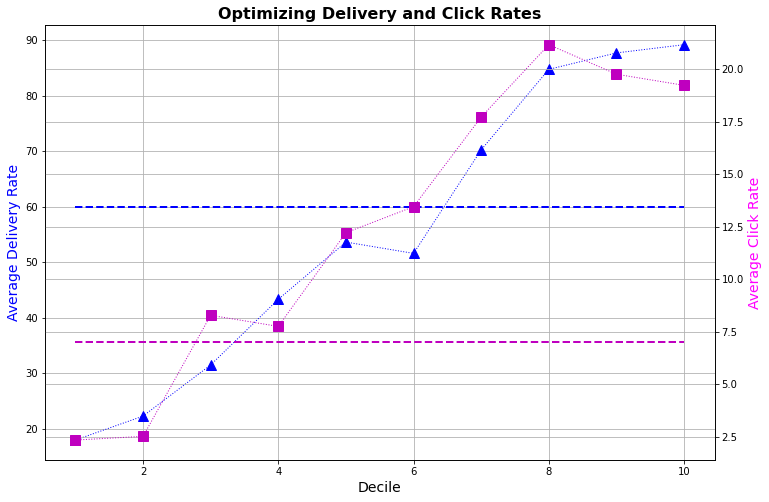

In [28]:
fig, ax1 = plt.subplots(figsize=(12,8))
  
color = 'blue'
ax1.set_xlabel('Decile',fontsize=14)
ax1.set_ylabel('Average Delivery Rate',fontsize=14, color=color)
ax1.plot(bin_names, drate_list,'b^:',markersize=10, linewidth=1)
ax1.plot(bin_names, avg_drate_threshold*np.ones((len(bin_names),1)),'b--', linewidth=2)

plt.grid(True)

ax2 = ax1.twinx()
  
color = 'magenta'
ax2.set_ylabel('Average Click Rate',fontsize=14, color=color)
ax2.plot(bin_names, crate_list,'ms:',markersize=10, linewidth=1)
ax2.plot(bin_names, avg_crate_threshold*np.ones((len(bin_names),1)),'m--', linewidth=2)
plt.title('Optimizing Delivery and Click Rates', fontweight ="bold",fontsize=16)

# plt.legend(['Delivery Rate','Click Rate'])

plt.grid(True)
plt.show()

In [29]:
def extract_class_df(df_prob_,hdr='conf'):
    tn=func_GetDFRows(df_prob_,hdr,'tn','eq')
    fn=func_GetDFRows(df_prob_,hdr,'fn','eq')
    fp=func_GetDFRows(df_prob_,hdr,'fp','eq')
    tp=func_GetDFRows(df_prob_,hdr,'tp','eq')
    return (tn,fn,fp,tp)

def make_subplot_pod(tp,fp,hdr,leg_a,leg_b,str1,bins1,stat,shrink)->None:
    leg1 = []
    if len(tp) > 0:
        sns_histplot(tp,hdr,bins1,stat,'b','--',shrink)
        leg1.append(str1+' '+leg_a)
    if len(fp) > 0:
        sns_histplot(fp,hdr,bins1,stat,'r',':',shrink)
        leg1.append(str1+' '+leg_b)
    plt.legend(leg1,fontsize=14)
    plt.xlabel('POD',fontsize=14)
    plt.ylabel('')
    plt.tick_params(axis='both', which='major', labelsize=18)
    return

#%%
def plot_POD(pred_train,pred_test,str1,str2,bins1,bins2,fignum,figsize,stat='count',\
             hdr='pos_prob',shrink=1):
    
    tn_train,fn_train,fp_train,tp_train = extract_class_df(pred_train)
    
    if pred_test is not None:
        tn_test,fn_test,fp_test,tp_test = extract_class_df(pred_test)
        
    plt.figure(num=fignum,figsize=figsize)
    plt.subplot(2,2,2)
    make_subplot_pod(tp_train,fp_train,hdr,'TP','FP',str1,bins1,stat,shrink)
    
    plt.subplot(2,2,1)
    make_subplot_pod(tn_train,fn_train,hdr,'TN','FN',str1,bins1,stat,shrink)
    
    if pred_test is not None:
        plt.subplot(2,2,4)
        make_subplot_pod(tp_test,fp_test,hdr,'TP','FP',str2,bins2,stat,shrink)
        
        plt.subplot(2,2,3)
        make_subplot_pod(tn_test,fn_test,hdr,'TN','FN',str2,bins2,stat,shrink)
        
    return

def sns_histplot(POD_test0_tn,hdr,bins,stat,color,linestyle,shrink):
    import seaborn as sns
    sns.histplot(data=POD_test0_tn, x=hdr, y=None, hue=None,\
                 weights=None, stat=stat, bins=bins, binwidth=None, binrange=None,\
                 discrete=None, cumulative=False, common_bins=True, common_norm=True,\
                 multiple='layer', element='bars', fill=False, shrink=shrink, kde=True, kde_kws=None,\
                 line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None,\
                 cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=color, log_scale=None,\
                 legend=True, linestyle=linestyle)
    return

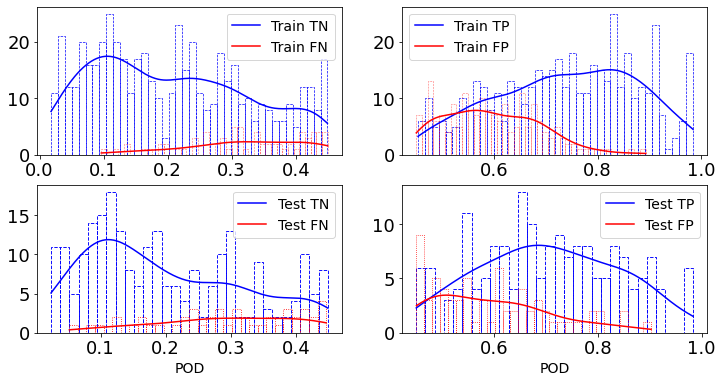

In [30]:
plot_POD(df_prob_train,df_prob_test,'Train','Test',40,30,1,(12,6),stat='count',\
             hdr='pos_prob',shrink=1)

In [31]:
indepen_vars = ['Circle']
# control_vars = ['SMS Language',
#                 'Day of Week', 
#                 'Median Day of Month ceil',
#                 'Avg SMS Length_cat',
#                 'Hour of Day']

control_vars = ['Day of Week',
             'Median Day of Month ceil',
             'Avg SMS Length_cat',
             'Hour of Day',
             'Median Num SMS Sent']

control_var_levels = {}
for i in range(len(control_vars)):
    var_i = control_vars[i]
    df_v_i = pd.DataFrame(np.unique(df[var_i].values).tolist())
    df_v_i.columns=[var_i]
    control_var_levels[i] = df_v_i

In [32]:
control_var_levels

{0:   Day of Week
 0      Friday
 1      Monday
 2    Saturday
 3      Sunday
 4    Thursday
 5     Tuesday
 6   Wednesday,
 1:     Median Day of Month ceil
 0                        1.0
 1                        2.0
 2                        3.0
 3                        4.0
 4                        5.0
 5                        6.0
 6                        7.0
 7                        8.0
 8                        9.0
 9                       10.0
 10                      11.0
 11                      12.0
 12                      13.0
 13                      14.0
 14                      15.0
 15                      16.0
 16                      17.0
 17                      18.0
 18                      19.0
 19                      20.0
 20                      21.0
 21                      22.0
 22                      23.0
 23                      24.0
 24                      25.0
 25                      26.0
 26                      27.0
 27                      28.0
 28

In [33]:
def customize_campaign(data, features, circle, df_bins, hour_of_day_start=None, hour_of_day_end=None, accepted_languages=None):
    
    index_name = 'SN'
    
    indepen_vars = ['Circle']
    control_vars = ['Day of Week',
                     'Median Day of Month ceil',
                     'Avg SMS Length_cat',
                     'Hour of Day',
                     'Median Num SMS Sent'
                   ]

    control_var_levels = {}
    for i in range(len(control_vars)):
        control_var = control_vars[i]
        df_unique_vals = pd.DataFrame(np.unique(data[control_var].values).tolist())
        df_unique_vals.columns=[control_var]
        control_var_levels[i] = df_unique_vals
        
    df_all_permutations = all_attribute_permutations(control_var_levels)
    
    df_indep = data[['Circle']]
    
    df_filter_by_circle = df_lib.func_GetDFRows(df_indep,'Circle',circle,'eq')
    df_filter_by_circle.drop_duplicates(keep='first',inplace=True)
    
    df_concat = [df_filter_by_circle, df_all_permutations]
    df_concat_permutations = all_attribute_permutations(df_concat)
    df_concat_permutations.index = np.arange(1,len(df_concat_permutations)+1)
    df_filter_by_circle.drop_duplicates(keep='first',inplace=True)
    df_concat_permutations_orig = df_concat_permutations.copy()
    
    df_concat_permutations = feature_decoding(df_concat_permutations,'Circle',circle_enc_key,None)
    df_concat_permutations = feature_decoding(df_concat_permutations,'Day of Week',weekday_enc_key,None)
    df_concat_permutations = feature_decoding(df_concat_permutations,'Avg SMS Length_cat',avg_sms_len_enc_key,None)
    
    prediction_new = prediction(clf,
                      df_concat_permutations,
                      None,
                      index_name,
                      df_concat_permutations.index,
                      features,
                      prob_threshold=0.5)

    df_prob_new = pd.concat([prediction_new['df_prob'],df_concat_permutations_orig],axis=1)

    df_prob_new_dec = map_deciles(df_prob_new,df_bins,sort_band='descending')
    
    #df_filter_with_class1 = df_lib.func_GetDFRows(df_prob_new_dec,'class_pred',1,'eq')
    
#     if accepted_languages!= None:
#         df_filter_with_language = df_filter_with_class1[df_filter_with_class1['SMS Language'].isin(accepted_languages)]
#         #df_filter_by_bands = df_lib.func_GetDFRows(df_filter_with_language,'band', 9, 'geq')
        
#     else:
#         #df_filter_by_bands = df_lib.func_GetDFRows(df_filter_with_class1,'band', 9, 'geq')
#         df_filter_with_language = df_filter_with_class1.copy()
        
    return df_prob_new_dec #df_filter_with_class1 #df_filter_with_language

#     df1=df_lib.func_GetDFRows(df1,'Hour of Day',9,'geq',18,'leq')
#     df1=df_lib.func_GetDFRows(df1,'Avg Day of Month_cat','week_1','eq')
#     df1=df_lib.func_GetDFRows(df1,'Day of Week','Monday','eq')

In [34]:
ktaka_df = customize_campaign(df, Xcols, 'Karnataka', df_bins)

<ipython-input-33-ff3655833e76>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_by_circle.drop_duplicates(keep='first',inplace=True)
<ipython-input-33-ff3655833e76>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_by_circle.drop_duplicates(keep='first',inplace=True)
/home/myshubhlife/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [42]:
ktaka_df

,neg_prob,pos_prob,class_pred,Circle,Day of Week,Median Day of Month ceil,Avg SMS Length_cat,Hour of Day,Median Num SMS Sent,band
3731,0.017099,0.982901,1.0,Karnataka,Friday,24.0,181-200,9,2.0,10
31411,0.017863,0.982137,1.0,Karnataka,Wednesday,11.0,181-200,9,2.0,10
31371,0.017863,0.982137,1.0,Karnataka,Wednesday,11.0,1-180,9,2.0,10
31571,0.017863,0.982137,1.0,Karnataka,Wednesday,12.0,181-200,9,2.0,10
31531,0.017863,0.982137,1.0,Karnataka,Wednesday,12.0,1-180,9,2.0,10
...,...,...,...,...,...,...,...,...,...,...
29608,0.990855,0.009145,0.0,Karnataka,Tuesday,31.0,1-180,3,3.0,1
29607,0.990855,0.009145,0.0,Karnataka,Tuesday,31.0,1-180,3,2.0,1
29606,0.990855,0.009145,0.0,Karnataka,Tuesday,31.0,1-180,2,3.0,1
29605,0.990855,0.009145,0.0,Karnataka,Tuesday,31.0,1-180,2,2.0,1


In [35]:
# weeks : week 1 - 1-7; week 2 - 8-14; week 3 - 15-21; week 4 - 22-28; week 5 - 29-31
circle_df = ktaka_df.copy()
circle_df.drop(['Median Num SMS Sent','neg_prob','class_pred'], axis=1, inplace=True)

circle_df.loc[((circle_df['Hour of Day']>=9) & (circle_df['Hour of Day']<=12)),'Session of Day']='9AM-12PM'
circle_df.loc[((circle_df['Hour of Day']>12) & (circle_df['Hour of Day']<=18)),'Session of Day']='12:01PM-6PM'
circle_df.loc[((circle_df['Hour of Day']>18) & (circle_df['Hour of Day']<=24)),'Session of Day']='6:01PM-12AM'
circle_df.loc[((circle_df['Hour of Day']>0) & (circle_df['Hour of Day']<=8)),'Session of Day']='12:01AM-8:59AM'

condition_band = (circle_df['band'].isin([10,9,8]))
condition_week = ((circle_df['Median Day of Month ceil']>14) & (circle_df['Median Day of Month ceil']<=21)) 
#condition_date = ((circle_df['Median Day of Month ceil']>14) & (circle_df['Median Day of Month ceil']<=21)) 
#condition_hour = ((circle_df['Hour of Day']>=9) & (circle_df['Hour of Day']<=12) )

In [36]:
circle_df[condition_band & condition_week].drop(['Median Day of Month ceil'], axis=1).drop_duplicates(['Day of Week','Session of Day'], keep='first').head(5) #.head(20)

,pos_prob,Circle,Day of Week,Avg SMS Length_cat,Hour of Day,band,Session of Day
32171,0.980283,Karnataka,Wednesday,1-180,9,10,9AM-12PM
2451,0.978129,Karnataka,Friday,181-200,9,10,9AM-12PM
32009,0.975414,Karnataka,Wednesday,1-180,8,10,12:01AM-8:59AM
12331,0.974797,Karnataka,Saturday,1-180,9,10,9AM-12PM
12329,0.972215,Karnataka,Saturday,1-180,8,10,12:01AM-8:59AM


In [37]:
def get_appropriate_df_for_campaign(permutation_circle_df, band_list = [10,9,8], 
                                    week_start_date=None, week_end_date=None, week_num=None):
    
    # weeks : week 1 - 1-7; week 2 - 8-14; week 3 - 15-21; week 4 - 22-28; week 5 - 29-31
    circle_df = permutation_circle_df.copy()
    circle_df.drop(['Median Num SMS Sent','neg_prob','class_pred'], axis=1, inplace=True)

    circle_df.loc[((circle_df['Hour of Day']>=9) & (circle_df['Hour of Day']<=12)),'Session of Day']='9AM-12PM'
    circle_df.loc[((circle_df['Hour of Day']>12) & (circle_df['Hour of Day']<=18)),'Session of Day']='12:01PM-6PM'
    circle_df.loc[((circle_df['Hour of Day']>18) & (circle_df['Hour of Day']<=24)),'Session of Day']='6:01PM-12AM'
    circle_df.loc[((circle_df['Hour of Day']>0) & (circle_df['Hour of Day']<=8)),'Session of Day']='12:01AM-8:59AM'

    condition_band = (circle_df['band'].isin(band_list))
    condition_week = ((circle_df['Median Day of Month ceil']>=week_start_date) & (circle_df['Median Day of Month ceil']<=week_end_date)) 
    
    final_df = circle_df[condition_band & condition_week].drop(['Median Day of Month ceil'], axis=1).drop_duplicates(['Day of Week','Session of Day'], keep='first').head(5) #.head(20)
    final_df['week'] = f'week_{week_num} : {week_start_date}-{week_end_date}'
    
    return final_df

In [38]:
def get_final_campaign_df(permutation_circle_df, band_list = [10,9,8]):
    
    week1 = get_appropriate_df_for_campaign(permutation_circle_df, band_list = band_list, 
                                    week_start_date=1, week_end_date=7, week_num=1)
    
    week2 = get_appropriate_df_for_campaign(permutation_circle_df, band_list = band_list, 
                                    week_start_date=8, week_end_date=14, week_num=2)
    
    week3 = get_appropriate_df_for_campaign(permutation_circle_df, band_list = band_list, 
                                    week_start_date=15, week_end_date=21, week_num=3)
    
    week4 = get_appropriate_df_for_campaign(permutation_circle_df, band_list = band_list, 
                                    week_start_date=22, week_end_date=28, week_num=4)
    
    week5 = get_appropriate_df_for_campaign(permutation_circle_df, band_list = band_list, 
                                    week_start_date=29, week_end_date=31, week_num=5)
    
    all_weeks = pd.concat([week1, week2, week3, week4, week5])
    
    return all_weeks

In [39]:
get_final_campaign_df(ktaka_df, band_list = [10,9,8])

,pos_prob,Circle,Day of Week,Avg SMS Length_cat,Hour of Day,band,Session of Day,week
30731,0.971119,Karnataka,Wednesday,1-180,9,10,9AM-12PM,week_1 : 1-7
10931,0.968658,Karnataka,Saturday,181-200,9,10,9AM-12PM,week_1 : 1-7
30769,0.966251,Karnataka,Wednesday,181-200,8,10,12:01AM-8:59AM,week_1 : 1-7
10929,0.966076,Karnataka,Saturday,181-200,8,10,12:01AM-8:59AM,week_1 : 1-7
1011,0.961307,Karnataka,Friday,181-200,9,10,9AM-12PM,week_1 : 1-7
31411,0.982137,Karnataka,Wednesday,181-200,9,10,9AM-12PM,week_2 : 8-14
1811,0.981724,Karnataka,Friday,181-200,9,10,9AM-12PM,week_2 : 8-14
11571,0.977912,Karnataka,Saturday,181-200,9,10,9AM-12PM,week_2 : 8-14
31409,0.977269,Karnataka,Wednesday,181-200,8,10,12:01AM-8:59AM,week_2 : 8-14
11729,0.975330,Karnataka,Saturday,181-200,8,10,12:01AM-8:59AM,week_2 : 8-14


In [65]:
get_appropriate_df_for_campaign(ktaka_df, band_list = [10,9,8], 
                                    week_start_date=14, week_end_date=20)

,neg_prob,pos_prob,class_pred,Circle,Day of Week,Avg SMS Length_cat,Hour of Day,band,Session of Day
32171,0.019717,0.980283,1.0,Karnataka,Wednesday,1-180,9,10,9AM-12PM
2131,0.020682,0.979318,1.0,Karnataka,Friday,181-200,9,10,9AM-12PM
12051,0.024494,0.975506,1.0,Karnataka,Saturday,181-200,9,10,9AM-12PM


In [56]:
def get_appropriate_bands(df_circle, band_avg_click_rate_df,
                          day_of_week=None, 
                          date_of_month=None, 
                          hour_of_day=[]):
    
    df_circle = df_circle.merge(band_avg_click_rate_df, on='band')
    
    final_df = df_circle[(df_circle['Day of Week']==day_of_week) &
                         (df_circle['Median Day of Month ceil']==date_of_month) &
                         (df_circle['Hour of Day'].isin(hour_of_day))]
    
    return final_df

In [58]:
get_appropriate_bands(ktaka_df,band_avg_click_rate_df, day_of_week='Tuesday', date_of_month=9, hour_of_day=[9,10,11,12])

,neg_prob,pos_prob,class_pred,Circle,Day of Week,Median Day of Month ceil,Avg SMS Length_cat,Hour of Day,Median Num SMS Sent,band,avg_click_rate
1110,0.152685,0.847315,1.0,Karnataka,Tuesday,9.0,181-200,9,2.0,10,19.228305
1456,0.175688,0.824312,1.0,Karnataka,Tuesday,9.0,1-180,9,2.0,10,19.228305
1526,0.180638,0.819362,1.0,Karnataka,Tuesday,9.0,201-300,9,2.0,10,19.228305
1740,0.194528,0.805472,1.0,Karnataka,Tuesday,9.0,181-200,9,3.0,10,19.228305
2190,0.217531,0.782469,1.0,Karnataka,Tuesday,9.0,1-180,9,3.0,9,19.758750
2286,0.222481,0.777519,1.0,Karnataka,Tuesday,9.0,201-300,9,3.0,9,19.758750
2589,0.236695,0.763305,1.0,Karnataka,Tuesday,9.0,300+,9,2.0,9,19.758750
3419,0.278538,0.721462,1.0,Karnataka,Tuesday,9.0,300+,9,3.0,9,19.758750
5805,0.355592,0.644408,1.0,Karnataka,Tuesday,9.0,181-200,10,2.0,8,21.165108
5921,0.359152,0.640848,1.0,Karnataka,Tuesday,9.0,201-300,10,2.0,8,21.165108


In [47]:
ktaka_df.merge(band_avg_click_rate_df, on='band')

,neg_prob,pos_prob,class_pred,Circle,Day of Week,Median Day of Month ceil,Avg SMS Length_cat,Hour of Day,Median Num SMS Sent,band,avg_click_rate
0,0.017099,0.982901,1.0,Karnataka,Friday,24.0,181-200,9,2.0,10,19.228305
1,0.017863,0.982137,1.0,Karnataka,Wednesday,11.0,181-200,9,2.0,10,19.228305
2,0.017863,0.982137,1.0,Karnataka,Wednesday,11.0,1-180,9,2.0,10,19.228305
3,0.017863,0.982137,1.0,Karnataka,Wednesday,12.0,181-200,9,2.0,10,19.228305
4,0.017863,0.982137,1.0,Karnataka,Wednesday,12.0,1-180,9,2.0,10,19.228305
...,...,...,...,...,...,...,...,...,...,...,...
34715,0.990855,0.009145,0.0,Karnataka,Tuesday,31.0,1-180,3,3.0,1,2.339738
34716,0.990855,0.009145,0.0,Karnataka,Tuesday,31.0,1-180,3,2.0,1,2.339738
34717,0.990855,0.009145,0.0,Karnataka,Tuesday,31.0,1-180,2,3.0,1,2.339738
34718,0.990855,0.009145,0.0,Karnataka,Tuesday,31.0,1-180,2,2.0,1,2.339738


In [46]:
ktaka_df_10 = ktaka_df[ktaka_df['band']==10]

In [47]:
ktaka_df_10['SMS Language'].value_counts()

Hindi      210
English    207
Kannada    162
Name: SMS Language, dtype: int64

In [48]:
ktaka_df['quartile'] = pd.qcut(ktaka_df['pos_prob'], q=4)

In [49]:
ktaka_df['quartile'].value_counts()

(0.499, 0.565]    822
(0.565, 0.653]    822
(0.76, 0.923]     822
(0.653, 0.76]     821
Name: quartile, dtype: int64

In [50]:
ktaka_df_top_q = func_GetDFRows(ktaka_df,'pos_prob',0.76,'gt',1,'leq')

In [51]:
ktaka_df_top_q

,neg_prob,pos_prob,class_pred,Circle,SMS Language,Day of Week,Session of Day,Avg SMS Length_cat,Avg Day of Month_cat,band,quartile
258,0.077271,0.922729,1.0,Karnataka,English,Monday,3.0,medium,week_3_h2,10,"(0.76, 0.923]"
267,0.086099,0.913901,1.0,Karnataka,English,Monday,3.0,short,week_3_h2,10,"(0.76, 0.923]"
1203,0.088784,0.911216,1.0,Karnataka,English,Wednesday,3.0,medium,week_3_h2,10,"(0.76, 0.923]"
447,0.091255,0.908745,1.0,Karnataka,English,Saturday,3.0,medium,week_3_h2,10,"(0.76, 0.923]"
1581,0.093140,0.906860,1.0,Karnataka,Hindi,Monday,3.0,medium,week_3_h2,10,"(0.76, 0.923]"
...,...,...,...,...,...,...,...,...,...,...,...
2322,0.238919,0.761081,1.0,Karnataka,Hindi,Tuesday,2.0,short,week_5,9,"(0.76, 0.923]"
2321,0.238919,0.761081,1.0,Karnataka,Hindi,Tuesday,2.0,short,week_4_h2,9,"(0.76, 0.923]"
2314,0.238919,0.761081,1.0,Karnataka,Hindi,Tuesday,2.0,short,week_1_h1,9,"(0.76, 0.923]"
2315,0.238919,0.761081,1.0,Karnataka,Hindi,Tuesday,2.0,short,week_1_h2,9,"(0.76, 0.923]"


In [52]:
ktaka_df_top_q['Avg SMS Length_cat'].value_counts()

medium    388
short     372
long       61
Name: Avg SMS Length_cat, dtype: int64

ktaka_df_10[ktaka_df_10['quartile'] == pd.Interval(left=0.881, right=0.911)]

ktaka_df_10['quartile'].value_counts()

In [54]:
ktaka_df_top_q[ktaka_df_top_q['quartile'] == pd.Interval(left=0.76, right=0.923)]['Day of Week'].value_counts()

Monday       198
Saturday     193
Wednesday    179
Thursday     161
Tuesday       37
Friday        31
Sunday        22
Name: Day of Week, dtype: int64

In [55]:
ktaka_df_top_q[ktaka_df_top_q['quartile'] == pd.Interval(left=0.76, right=0.923)]['Avg Day of Month_cat'].value_counts()

week_3_h2    137
week_2_h1     90
week_4_h1     90
week_2_h2     90
week_3_h1     90
week_1_h2     81
week_1_h1     81
week_5        81
week_4_h2     81
Name: Avg Day of Month_cat, dtype: int64

In [56]:
ktaka_df_top_q[ktaka_df_top_q['quartile'] == pd.Interval(left=0.76, right=0.923)]['SMS Language'].value_counts()

Hindi      300
English    290
Kannada    231
Name: SMS Language, dtype: int64

In [57]:
ktaka_df_top_q[ktaka_df_top_q['quartile'] == pd.Interval(left=0.76, right=0.923)]['Session of Day'].value_counts()

3.0    301
4.0    250
2.0    231
6.0     23
5.0     16
Name: Session of Day, dtype: int64

In [161]:
ktaka_df_10[(ktaka_df_10['quartile'] == pd.Interval(left=0.881, right=0.911)) &
            (ktaka_df_10['Avg Day of Month_cat']=='week_2') &
            (ktaka_df_10['Day of Week']=='Monday')]['SMS Language'].value_counts()

Hindi      14
English    14
Name: SMS Language, dtype: int64

In [126]:
sorted_df = ktaka_df.sort_values(by=['quartile'], ascending=False).sort_values(by=['Session of Day'], ascending=True)

In [127]:
sorted_df

,neg_prob,pos_prob,class_pred,Circle,SMS Language,Day of Week,Session of Day,Avg SMS Length_cat,Avg Day of Month_cat,band,quartile
93,0.154545,0.845455,1.0,Karnataka,English,Monday,1.0,short,week_1,10,"(0.842, 0.91]"
96,0.106615,0.893385,1.0,Karnataka,English,Monday,1.0,short,week_4,10,"(0.842, 0.91]"
90,0.106615,0.893385,1.0,Karnataka,English,Monday,1.0,medium,week_2,10,"(0.842, 0.91]"
94,0.106615,0.893385,1.0,Karnataka,English,Monday,1.0,short,week_2,10,"(0.842, 0.91]"
1606,0.272999,0.727001,1.0,Karnataka,Kannada,Tuesday,1.0,short,week_2,9,"(0.724, 0.761]"
...,...,...,...,...,...,...,...,...,...,...,...
504,0.246205,0.753795,1.0,Karnataka,English,Tuesday,7.0,short,week_4,9,"(0.724, 0.761]"
413,0.195346,0.804654,1.0,Karnataka,English,Thursday,7.0,medium,week_1,10,"(0.801, 0.842]"
420,0.175474,0.824526,1.0,Karnataka,English,Thursday,7.0,short,week_4,10,"(0.801, 0.842]"
1425,0.196139,0.803861,1.0,Karnataka,Kannada,Saturday,7.0,short,week_1,10,"(0.801, 0.842]"


In [96]:
dff = fr_lib.func_ReadCSVFile(pathName=pname, fileName=fname)[0]
dff.set_index('SN',inplace=True)

In [98]:
dff

,Circle,SMS Language,Day of Week,Hour of Day,sms_sent,sms_delivered,delivery_rate,sms_clicked,clicked_rate,Avg Num SMS Sent,...,Avg Timelag (s) wo 0,Median Timelag (s) wo 0,Avg Day of Month,Median Day of Month,Avg Day of Month wo 0,Median Day of Month wo 0,Avg Num Words,Median Num Words,Avg Num Words wo 0,Median Num Words wo 0
SN,,,,,,,,,,,,,,,,,,,,,
0,Andhra Pradesh,English,Friday,9,461,438.0,95.010846,77.0,17.579909,2.0,...,2497.259740,3.0,24.000000,24.0,24.000000,24.0,29.000000,29.0,29.000000,29.0
1,Andhra Pradesh,English,Friday,10,13919,7784.0,55.923558,780.0,10.020555,2.0,...,19488.629160,2.0,2.014225,2.0,2.014225,2.0,33.996767,34.0,33.996767,34.0
2,Andhra Pradesh,English,Friday,11,2238,366.0,16.353887,34.0,9.289617,2.0,...,2.968750,2.5,7.080429,2.0,7.080429,2.0,33.995532,34.0,33.995532,34.0
3,Andhra Pradesh,English,Friday,12,832,633.0,76.081731,106.0,16.745656,2.0,...,8016.303922,27.0,11.331731,12.0,11.331731,12.0,36.617788,37.0,36.617788,37.0
4,Andhra Pradesh,English,Friday,13,12,10.0,83.333333,0.0,0.000000,2.0,...,0.000000,0.0,11.000000,12.0,11.000000,12.0,36.000000,37.0,36.000000,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,West Bengal-Andaman Nicobar,English,Wednesday,15,9,0.0,0.000000,0.0,0.000000,2.0,...,0.000000,0.0,8.000000,8.0,8.000000,8.0,22.000000,22.0,22.000000,22.0
1764,West Bengal-Andaman Nicobar,English,Wednesday,16,7,5.0,71.428571,0.0,0.000000,2.0,...,0.000000,0.0,11.000000,11.0,11.000000,11.0,32.000000,32.0,32.000000,32.0
1765,West Bengal-Andaman Nicobar,English,Wednesday,19,70,64.0,91.428571,10.0,15.625000,2.0,...,39.000000,4.0,22.114286,22.0,22.114286,22.0,30.185714,29.0,30.185714,29.0


In [100]:
ap = dff[dff['Circle']=='Andhra Pradesh']

<BarContainer object of 89 artists>

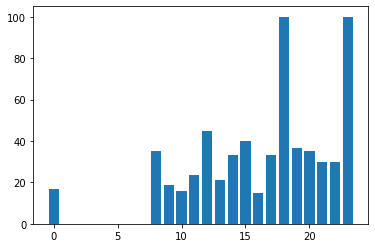

In [102]:
ap['Hour of Day'], ap['clicked_rate']

In [107]:
dff.groupby(['Circle','Hour of Day'])[['clicked_rate']].agg(np.mean)

clicked_rate
Circle                      Hour of Day              
Andhra Pradesh              0                5.555556
                            1                0.000000
                            2                0.000000
                            8               17.851331
                            9               13.531964
...                                               ...
West Bengal-Andaman Nicobar 19              21.875000
                            20               8.000000
                            21               0.000000
                            22               0.000000
                            23              25.000000

[444 rows x 1 columns]

In [108]:
dff['Circle'].value_counts()

Andhra Pradesh                      89
Maharashtra-Goa                     88
Delhi                               87
Karnataka                           87
Mumbai                              84
Uttar Pradesh (East)                83
Madhya Pradesh-Chattisgarh          83
Gujarat                             82
Bihar-Jharkhand                     80
Tamil Nadu                          79
Rajasthan                           79
Haryana                             76
Uttar Pradesh (West)-Uttarakhand    74
Orissa                              74
Punjab                              73
Assam                               69
Chennai                             69
Kolkata                             68
West Bengal-Andaman Nicobar         65
Kerala                              60
Tamil Nadu-Chennai                  56
Jammu-Kashmir                       56
North East                          55
Himachal Pradesh                    52
Name: Circle, dtype: int64